In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
import os

In [2]:
sys.path.append('../scripts')
log_dir = '../logs/' 

In [12]:
from data_cleaning import clean_missing_data,handle_outliers,encode_categorical
from eda import get_basic_stats,get_correlation_matrix,analyze_promo_effect,store_type_analysis

In [4]:
logging.basicConfig(filename=os.path.join(log_dir, 'rossmann_eda.log'), 
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

### Data Loading and Cleaning

In [5]:
train_df = pd.read_csv('../data/train.csv', parse_dates=['Date'])
test_df = pd.read_csv('../data/test.csv', parse_dates=['Date'])
store_df = pd.read_csv('../data/store.csv')

C:\Users\Kalea\AppData\Local\Temp\ipykernel_21904\4033360132.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('../data/train.csv', parse_dates=['Date'])


In [6]:
# Merge dataframes
train_df = pd.merge(train_df, store_df, on='Store', how='left')
test_df = pd.merge(test_df, store_df, on='Store', how='left')

In [7]:
# logging.info("Data loaded and merged successfully.")

In [8]:
train_df.info()
test_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
missing_per = train_df.isna().sum() / len(train_df) * 100
missing_per_test = test_df.isna().sum() / len(test_df) *100
missing_per 

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

Handle missing values

In [13]:
train_df= clean_missing_data(train_df)

In [14]:
train_df.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Outlier detection and handling

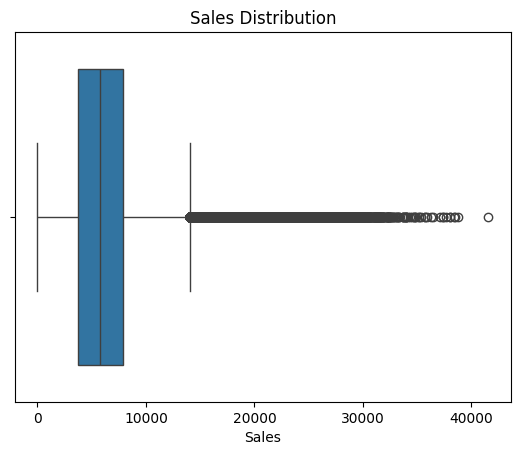

In [15]:
sns.boxplot(x=train_df['Sales'])
plt.title('Sales Distribution')
plt.show()

In [16]:
upper_bound = train_df['Sales'].quantile(0.99)
train_df['Sales'] = np.where(train_df['Sales'] > upper_bound, upper_bound, train_df['Sales'])


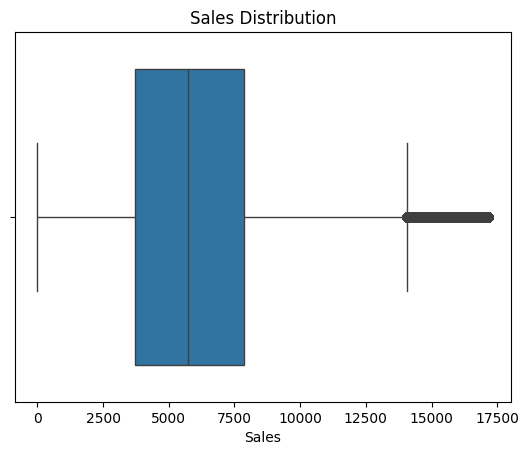

In [17]:
sns.boxplot(x=train_df['Sales'])
plt.title('Sales Distribution')
plt.show()

In [25]:
logging.info("Outliers on sales handled.")

Promo distribution acorss both datasets

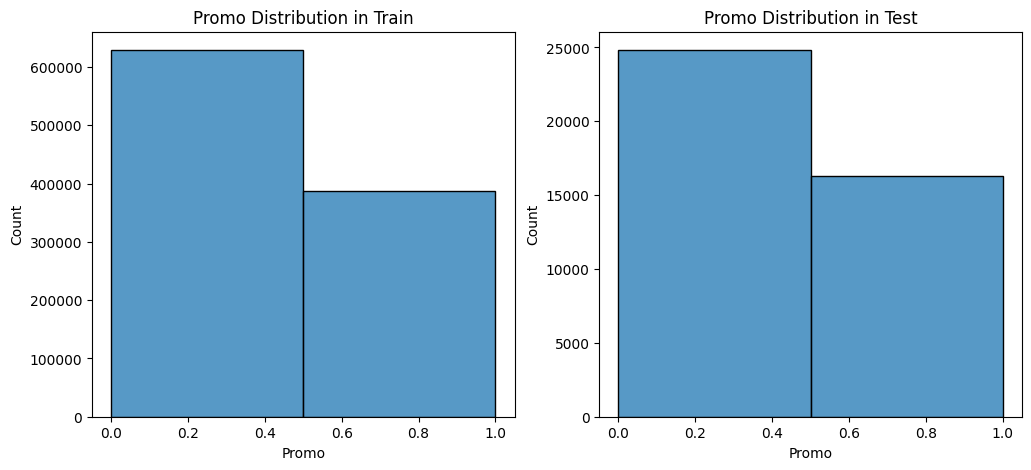

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_df['Promo'], ax=ax[0], bins=2)
sns.histplot(test_df['Promo'], ax=ax[1], bins=2)
ax[0].set_title('Promo Distribution in Train')
ax[1].set_title('Promo Distribution in Test')
plt.show()

In [1]:
# logging.info("Promo Distribution between test and train almost similar")

sales behavior before, during, and after holidays

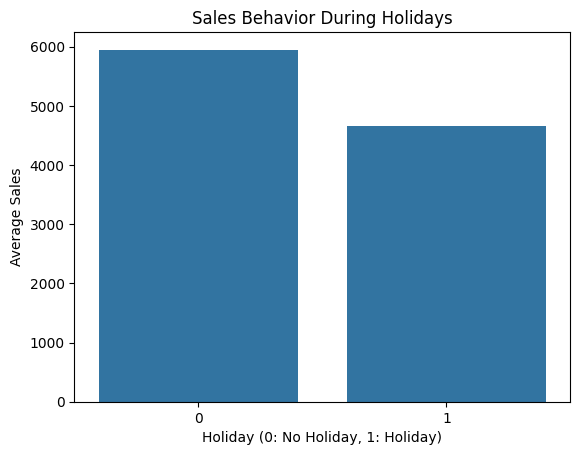

In [30]:
train_df['Holiday'] = train_df['StateHoliday'].apply(lambda x: 1 if x != '0' else 0)

# Group by 'Holiday' and calculate average sales
holiday_sales = train_df.groupby('Holiday')['Sales'].mean() 

# Plot the average sales
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.xlabel('Holiday (0: No Holiday, 1: Holiday)')
plt.ylabel('Average Sales')
plt.title('Sales Behavior During Holidays')
plt.show()

In [32]:
logging.info("sales behavior during holiday slightly less than the no holiday")

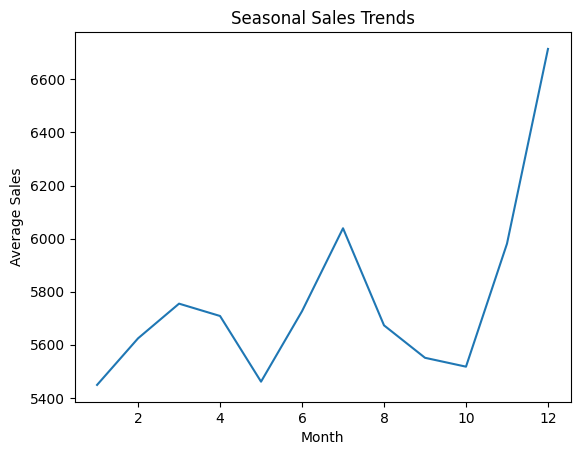

In [31]:
train_df['Month'] = train_df['Date'].dt.month
train_df['Year'] = train_df['Date'].dt.year

# Group by month and calculate average sales
monthly_sales = train_df.groupby('Month')['Sales'].mean()

# Plot monthly sales
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Seasonal Sales Trends')
plt.show()

In [33]:
logging.info("average sales seems to increase during later parts of the year (end of the year)")

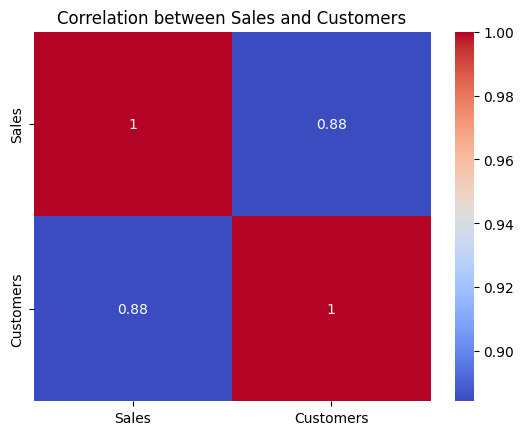

In [34]:
correlation = train_df[['Sales', 'Customers']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Sales and Customers')
plt.show()

In [39]:
logging.info("there is a strong positive correlation between sales and Customers")

Promo impact on sales and customers 

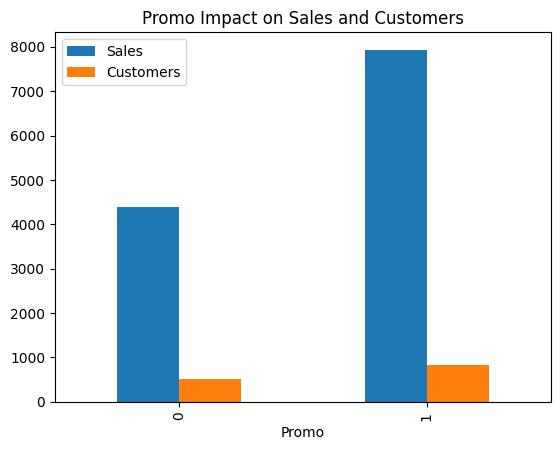

In [40]:
# Group by 'Promo' and calculate average sales and customers
promo_stats = train_df.groupby('Promo')[['Sales', 'Customers']].mean()

# Plot the results
promo_stats.plot(kind='bar')
plt.title('Promo Impact on Sales and Customers')
plt.show()


In [41]:
logging.info("promo increases the number of sales while also slighlty increaing the number of customers")

In [46]:
# Calculate average sales lift during promo for each store
store_promo_lift = train_df.groupby('Store').apply(
    lambda x: (x[x['Promo'] == 1]['Sales'].mean() - 
              x[x['Promo'] == 0]['Sales'].mean()) / 
              x[x['Promo'] == 0]['Sales'].mean() 
)

# Identify stores with high promo lift
top_stores = store_promo_lift.nlargest(10)
top_stores

C:\Users\Kalea\AppData\Local\Temp\ipykernel_5828\2715276069.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_promo_lift = train_df.groupby('Store').apply(


Store
198     2.258195
607     1.889831
543     1.759064
575     1.737033
693     1.608417
271     1.606881
96      1.575477
1108    1.567058
635     1.559421
552     1.556643
dtype: float64

Sales Trends by Day of Week

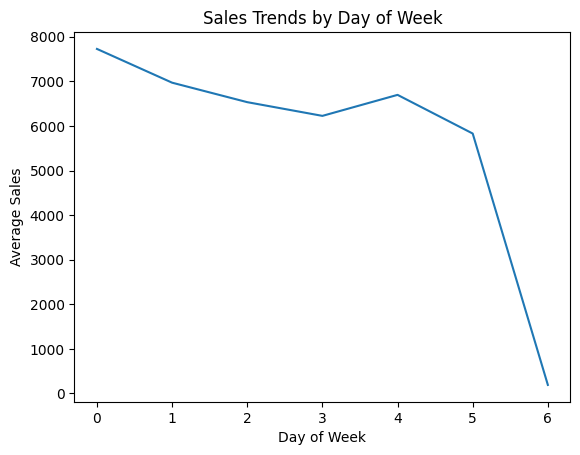

In [47]:
#  Create a new column for 'DayOfWeek'
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek 

# Group by 'DayOfWeek' and calculate average sales
day_of_week_sales = train_df.groupby('DayOfWeek')['Sales'].mean()

# Plot the average sales
sns.lineplot(x=day_of_week_sales.index, y=day_of_week_sales.values)
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.title('Sales Trends by Day of Week')
plt.show()

In [48]:
logging.info("sales drastically decreases during the weekends and is the highest on mondays")

sales comparision for stores open all weekdays

Average Weekend Sales: 10908.854104477612
Average Weekday Sales: 12187.963946587537


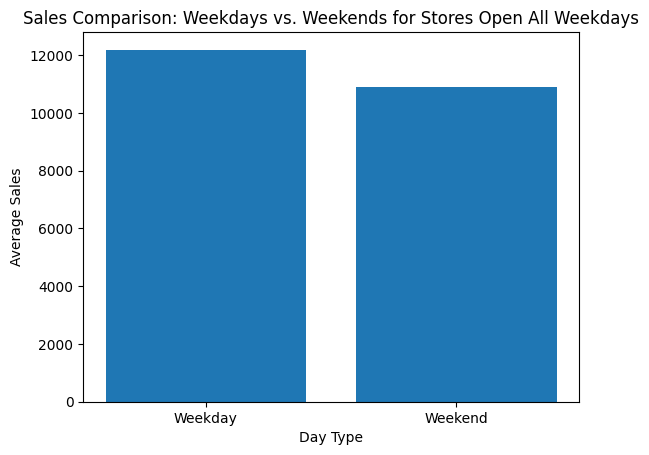

In [50]:
all_weekdays_open_stores = train_df.groupby('Store')['Open'].agg(lambda x: (x == 1).all()).loc[lambda x: x].index.tolist()

# Filter the DataFrame for these stores
stores_open_all_weekdays_df = train_df[train_df['Store'].isin(all_weekdays_open_stores)]

# Calculate average weekend sales for these stores
weekend_sales = stores_open_all_weekdays_df[stores_open_all_weekdays_df['DayOfWeek'].isin([5, 6])]['Sales'].mean()

# Calculate average weekday sales for these stores
weekday_sales = stores_open_all_weekdays_df[~stores_open_all_weekdays_df['DayOfWeek'].isin([5, 6])]['Sales'].mean()

# Compare weekend and weekday sales
print(f"Average Weekend Sales: {weekend_sales}")
print(f"Average Weekday Sales: {weekday_sales}")

# Visualize the comparison
plt.bar(['Weekday', 'Weekend'], [weekday_sales, weekend_sales])
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.title('Sales Comparison: Weekdays vs. Weekends for Stores Open All Weekdays')
plt.show()


Sales by Store Type and Assortment

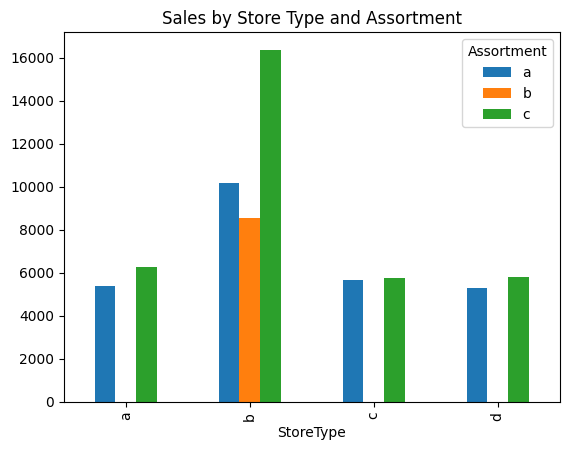

In [49]:
# Group by 'StoreType' and 'Assortment' and calculate average sales
store_type_sales = train_df.groupby(['StoreType', 'Assortment'])['Sales'].mean()

# Plot the average sales
store_type_sales.unstack().plot(kind='bar')
plt.title('Sales by Store Type and Assortment')
plt.show()

In [51]:
logging.info("Store B has overall bigger sales and much bigger sales on assortment c (extended features)")

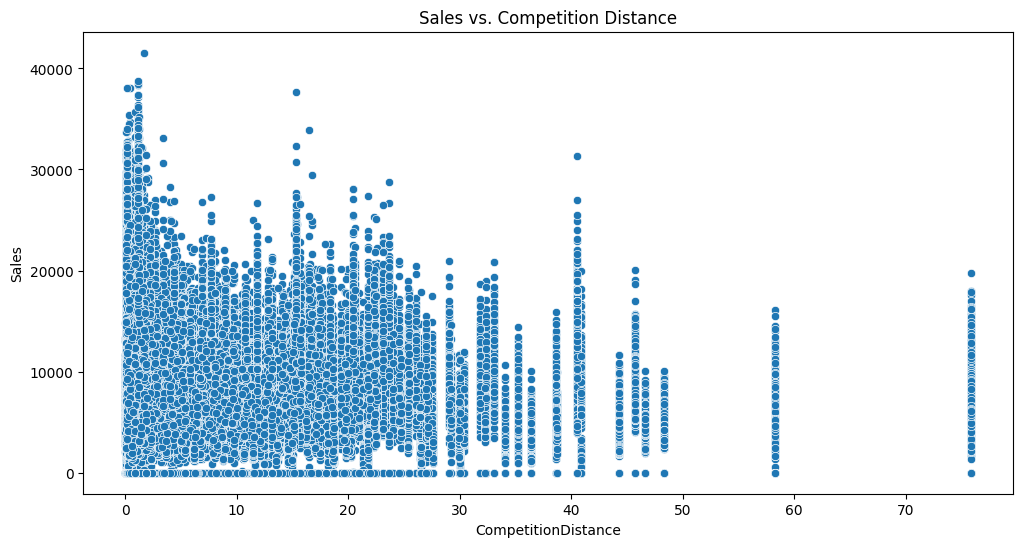

In [26]:
# Plot the relationship between 'CompetitionDistance' and 'Sales'
plt.figure(figsize=(12, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train_df)
plt.title('Sales vs. Competition Distance')
plt.show()

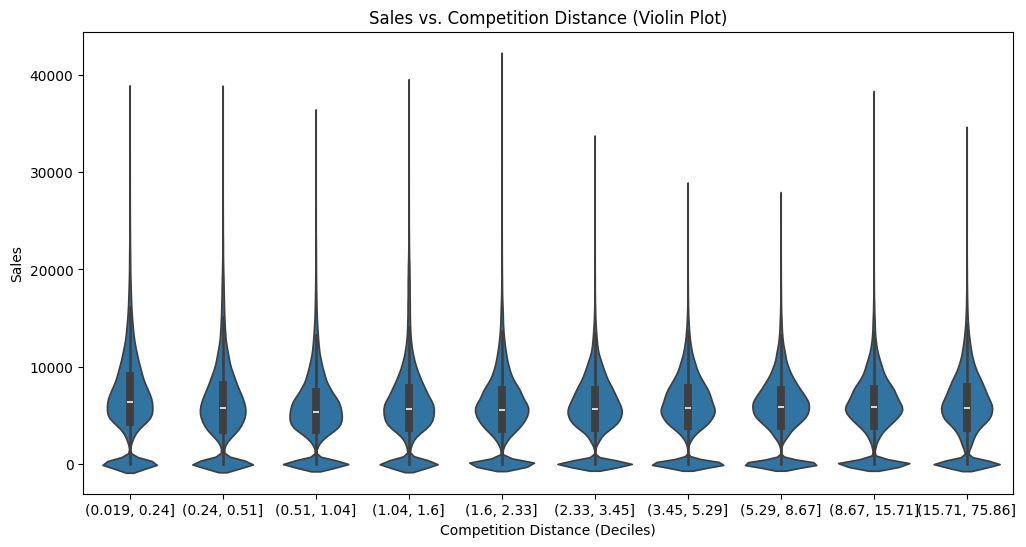

In [24]:
plt.figure(figsize=(12, 6))
sns.violinplot(x=pd.qcut(train_df['CompetitionDistance'], q=10), y='Sales', data=train_df)
plt.xlabel('Competition Distance (Deciles)')
plt.title('Sales vs. Competition Distance (Violin Plot)')
plt.show()

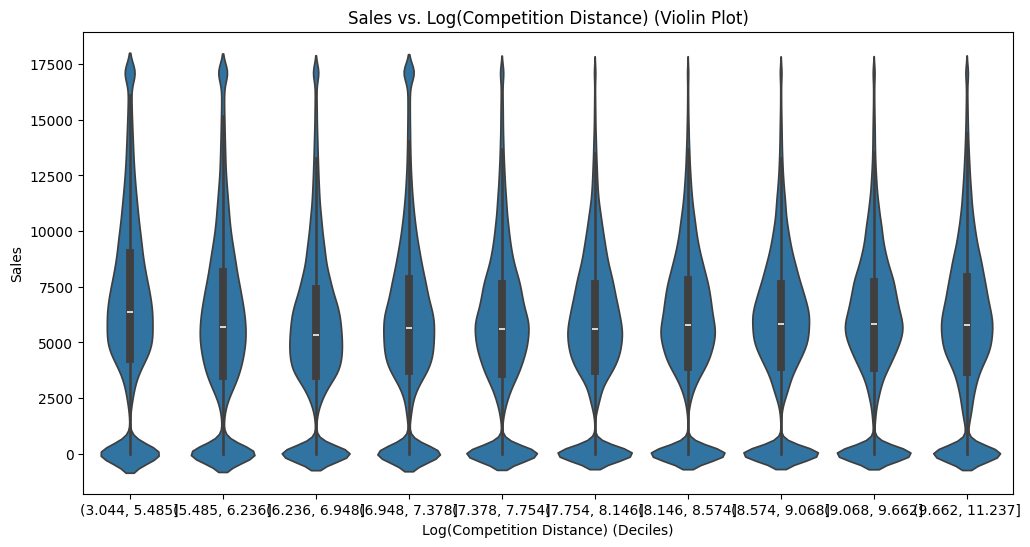

In [18]:
train_df['Log_CompetitionDistance'] = np.log1p(train_df['CompetitionDistance'])

plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
sns.violinplot(x=pd.qcut(train_df['Log_CompetitionDistance'], q=10), y='Sales', data=train_df)
plt.xlabel('Log(Competition Distance) (Deciles)')
plt.title('Sales vs. Log(Competition Distance) (Violin Plot)')
plt.show()